https://ggodong.tistory.com/21

In [1]:
from keras import models, layers
from keras.applications import VGG16
from keras import Input
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint
import os
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import math
from keras.models import load_model
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
 
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
 
train_dir = os.path.join('./Dataset/Train')
val_dir = os.path.join('./Dataset/Validation')
test_dir = os.path.join('./Dataset/Test')

In [2]:
train_generator = train_datagen.flow_from_directory(train_dir, batch_size=16, target_size=(220, 200), color_mode='rgb')
val_generator = val_datagen.flow_from_directory(val_dir, batch_size=16, target_size=(220, 200), color_mode='rgb')

input_tensor = Input(shape=(220, 200, 3), dtype='float32', name='input')

Found 160000 images belonging to 2 classes.
Found 22598 images belonging to 2 classes.


In [3]:
pre_trained_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(220, 200, 3))
pre_trained_vgg.trainable = False
pre_trained_vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 220, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 220, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 220, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 110, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 110, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 110, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 55, 50, 128)       0     

In [4]:
additional_model = models.Sequential()
additional_model.add(pre_trained_vgg)
additional_model.add(layers.Flatten())
additional_model.add(layers.Dense(4096, activation='relu'))
additional_model.add(layers.Dense(2048, activation='relu'))
additional_model.add(layers.Dense(1024, activation='relu'))
additional_model.add(layers.Dense(2, activation='sigmoid'))


additional_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 4096)              75501568  
_________________________________________________________________
dense_1 (Dense)              (None, 2048)              8390656   
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 2050      
Total params: 100,707,138
Trainable params: 85,992,450
Non-trainable params: 14,714,688
__________________________________

In [19]:
checkpoint = ModelCheckpoint(filepath='pretrained_VGG_weight.hdf5', 
            monitor='loss', 
            mode='min', 
            save_best_only=True)
 
additional_model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=2e-5), metrics=['acc'])


history = additional_model.fit_generator(train_generator, 
            steps_per_epoch=math.ceil(train_generator.n / train_generator.batch_size), 
            epochs=50, 
            validation_data=val_generator, 
            validation_steps=math.ceil(val_generator.n / val_generator.batch_size), 
            callbacks=[checkpoint])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
10000/10000 [==============================] - 668s 67ms/step - loss: 0.0581 - acc: 0.9822 - val_loss: 0.1900 - val_acc: 0.9536
Epoch 2/50
10000/10000 [==============================] - 662s 66ms/step - loss: 0.0549 - acc: 0.9829 - val_loss: 0.1850 - val_acc: 0.9542
Epoch 3/50
10000/10000 [==============================] - 669s 67ms/step - loss: 0.0539 - acc: 0.9833 - val_loss: 0.1858 - val_acc: 0.9543
Epoch 4/50
10000/10000 [==============================] - 674s 67ms/step - loss: 0.0531 - acc: 0.9835 - val_loss: 0.1846 - val_acc: 0.9542
Epoch 5/50
10000/10000 [==============================] - 664s 66ms/step - loss: 0.0526 - acc: 0.9836 - val_loss: 0.1798 - val_acc: 0.9536
Epoch 6/50
10000/10000 [==============================] - 674s 67ms/step - loss: 0.0522 - acc: 0.9837 - val_loss: 0.1827 - val_acc: 0.9543
Epoch 7/50
10000/10000 [==============================] - 672s 67ms/step - loss: 0.0518 - 

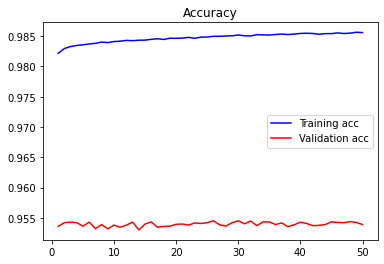

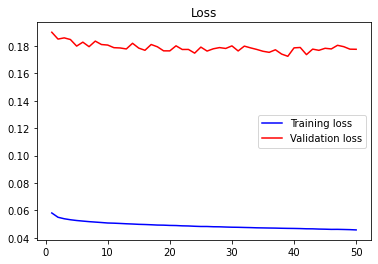

In [20]:
# number of train & validation samples 
# print(train_generator.n)
# print(val_generator.n)
 
# number of train & val batch_size
# print(train_generator.batch_size)
# print(val_generator.batch_size)
 
 
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(1, len(acc) + 1)
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Loss')
plt.legend()
 
plt.show()

In [3]:
additional_model = load_model('pretrained_VGG_weight.hdf5')

랜덤 사진 테스트

In [37]:
test_set = test_datagen.flow_from_directory('./Dataset/Test', target_size=(220, 200),batch_size=1, class_mode='binary', save_to_dir='./' , save_prefix='test', save_format='png')
# test_set = test_datagen.flow_from_dataframe(x_col='apink.jpg',target_size=(220,200), directory='./Dataset/Test')

Found 19999 images belonging to 2 classes.


In [38]:
images = []
import cv2


img, label = test_set.next()
n_img = len(label)

base = cv2.cvtColor(img[0], cv2.COLOR_RGB2BGR)  # keras는 RGB, openCV는 BGR이라 변경함
for idx in range(n_img - 1):
    img2 = cv2.cvtColor(img[idx + 1], cv2.COLOR_RGB2BGR)
    base = np.hstack((base, img2))
images.append(base)
images = np.concatenate(images)
img_test_a = np.uint8(images*255) 
img = images[0]
# cv2.imwrite('./test_1.jpg',img_test_a)
for idx in range(len(images) - 1):
    img = np.vstack((img, images[idx + 1]))
# cv2.imshow('result', img)
# cv2.imwrite('./test.jpg',img)

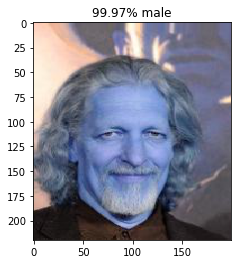

In [39]:
test_input = preprocess_input(np.expand_dims(img_test_a.copy(), axis=0))

output = additional_model.predict(test_input)

plt.figure(figsize=(4,4))
if output[0][1] > 0.9:
    plt.title('%.2f%% male' % (output[0][1]/(output[0][0]+output[0][1])*100))
else:
    plt.title('%.2f%% female' % (output[0][0]/(output[0][0]+output[0][1])*100))
plt.imshow(img_test_a.astype(np.uint8))

특정 사진 테스트

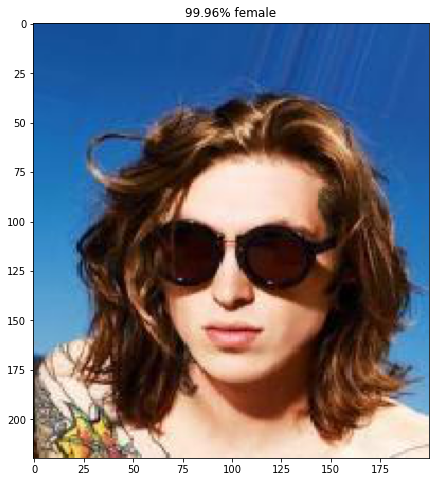

In [33]:
test_img = img_to_array(load_img(os.path.join('./Dataset/Test', '179343.jpg'), target_size=(220,200)))

test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0))

pred = additional_model.predict(test_input)

plt.figure(figsize=(8,8))
if pred[0][1] > 0.9:
    plt.title('%.2f%% male' % (pred[0][1] * 100))
else:
    plt.title('%.2f%% female' % (pred[0][0] * 100))
plt.imshow(test_img.astype(np.uint8))